In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import json
import cv2

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
TRAIN_PATH = os.path.join('data', 'train')
TEST_PATH = os.path.join('data', 'test')

In [4]:
emotion_dict = {
    'angry':0,
    'disgusted':1,
    'fearful':2,
    'happy':3,
    'neutral':4,
    'sad':5,
    'surprised':6
}

In [5]:
def emotion_to_vec(emotion):
    vec = np.zeros((7,))
    vec[emotion_dict[emotion]]=1
    return vec

In [6]:
train = tf.data.Dataset.list_files(os.path.join(TRAIN_PATH,'*',"*.png"), shuffle = False)
test = tf.data.Dataset.list_files(os.path.join(TEST_PATH,'*',"*.png"), shuffle = False)

In [7]:
train_emotions = train.as_numpy_iterator()
test_emotions = test.as_numpy_iterator()

In [8]:
print(len(train))
print(len(test))


28709
7178


In [9]:
def get_emotion(image_name):
    emotion = image_name.split(b'\\')[2].decode('utf-8')
    return emotion_to_vec(emotion)

In [10]:
def load_image(image):
    byte_img = tf.io.read_file(image)
    #print(type(original))
    original = tf.image.decode_png(byte_img, channels=3)
    return original/255

In [11]:
train = train.map(load_image)
test = test.map(load_image)

In [12]:
#type(train.as_numpy_iterator())
train.as_numpy_iterator().next().shape

(48, 48, 3)

In [13]:
train_emo = tf.data.Dataset.from_tensor_slices([get_emotion(image_name) for image_name in train_emotions])
test_emo = tf.data.Dataset.from_tensor_slices([get_emotion(image_name) for image_name in test_emotions])

In [14]:
print(len(train))
print(len(train_emo))

28709
28709


In [15]:
print(type(train))
print(type(train_emo))

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [16]:
train_all = tf.data.Dataset.zip((train,train_emo))
test_all = tf.data.Dataset.zip((test,test_emo))

In [17]:
len(train_all)

28709

In [18]:
train_all.as_numpy_iterator().next()[1]

array([1., 0., 0., 0., 0., 0., 0.])

In [19]:
train=train_all
test=test_all

In [20]:
im = train.as_numpy_iterator().next()[0]

In [21]:
im[0]

array([[0.27450982, 0.27450982, 0.27450982],
       [0.3137255 , 0.3137255 , 0.3137255 ],
       [0.32156864, 0.32156864, 0.32156864],
       [0.28235295, 0.28235295, 0.28235295],
       [0.22745098, 0.22745098, 0.22745098],
       [0.22745098, 0.22745098, 0.22745098],
       [0.23529412, 0.23529412, 0.23529412],
       [0.24705882, 0.24705882, 0.24705882],
       [0.21176471, 0.21176471, 0.21176471],
       [0.22745098, 0.22745098, 0.22745098],
       [0.23529412, 0.23529412, 0.23529412],
       [0.1882353 , 0.1882353 , 0.1882353 ],
       [0.34901962, 0.34901962, 0.34901962],
       [0.4509804 , 0.4509804 , 0.4509804 ],
       [0.4745098 , 0.4745098 , 0.4745098 ],
       [0.46666667, 0.46666667, 0.46666667],
       [0.4509804 , 0.4509804 , 0.4509804 ],
       [0.43137255, 0.43137255, 0.43137255],
       [0.38431373, 0.38431373, 0.38431373],
       [0.35686275, 0.35686275, 0.35686275],
       [0.32941177, 0.32941177, 0.32941177],
       [0.32941177, 0.32941177, 0.32941177],
       [0.

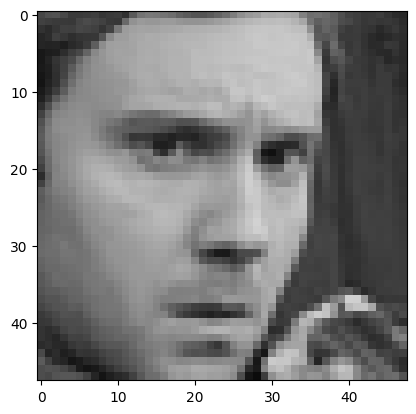

In [22]:
plt.imshow(im)

In [23]:
image_generator = test.batch(4).as_numpy_iterator()

In [24]:
plot_images = image_generator.next()

<class 'numpy.ndarray'>
48
<class 'numpy.ndarray'>
48
<class 'numpy.ndarray'>
48
<class 'numpy.ndarray'>
48


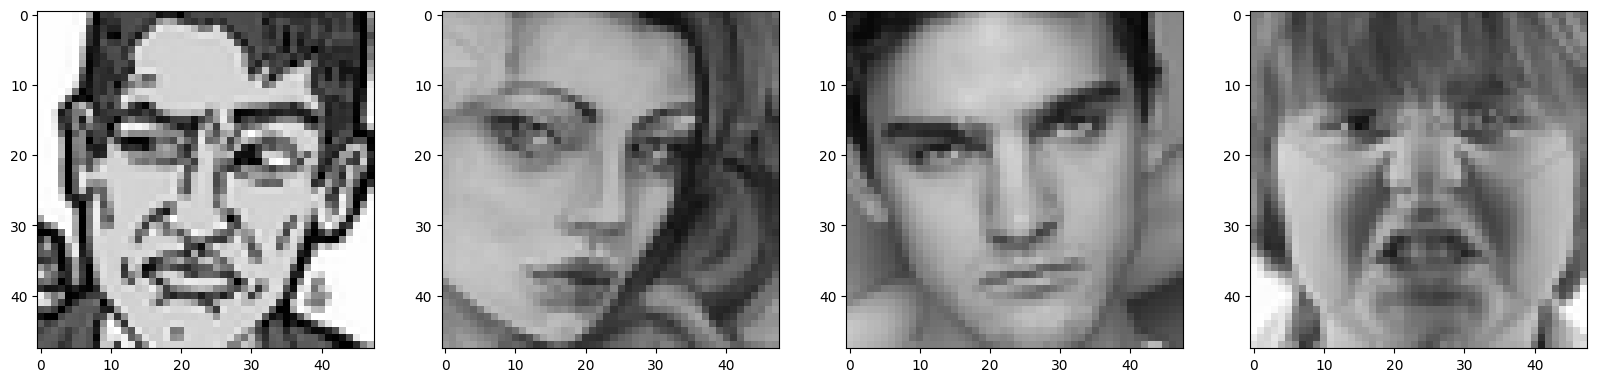

In [25]:
fig, ax = plt.subplots(ncols = 4, figsize =(20,20))
for idx, data in enumerate(plot_images[0]):
    print(type(data))
    print(len(data))
    ax[idx].imshow(data)
plt.show()

In [26]:
def prepare_data(data):
    data = data.shuffle(30000)
    data = data.batch(8)
    return data.prefetch(4)

In [27]:
train = prepare_data(train)
test = prepare_data(test)

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [29]:
#downloading vgg:
vgg = VGG16(include_top=False)

In [30]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [31]:
def build_model():
    input_layer = Input(shape =(48,48,3))
    vgg = VGG16(include_top=False)(input_layer)
     
    
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(7, activation='sigmoid')(class1)
    
    emotionreader = Model(inputs=input_layer,outputs=class2)
    
    return emotionreader

In [91]:
emotion_reader = build_model()

In [92]:
emotion_reader.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              1050624   
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 14343     
Total params: 15,779,655
Trainable params: 15,779,655
Non-trainable params: 0
_________________________________________________________________


In [93]:
res = train.as_numpy_iterator().next()


In [94]:
X, y = res

In [95]:
X.shape

(8, 48, 48, 3)

In [96]:
type(y)

numpy.ndarray

In [97]:
emotion = emotion_reader.predict([X])

In [98]:
type(emotion)

numpy.ndarray

In [99]:
for e in emotion:
    print(e)

[0.4588163  0.48672104 0.37716696 0.49309632 0.58760625 0.48989803
 0.48513365]
[0.43372405 0.5458175  0.33934918 0.47039115 0.56269974 0.4960637
 0.48984098]
[0.2675708  0.47297943 0.36423895 0.37462756 0.61555517 0.5182499
 0.5139017 ]
[0.40305158 0.54896927 0.27910694 0.43156266 0.6205004  0.54789513
 0.551222  ]
[0.42949775 0.50763905 0.38560835 0.48678577 0.61685896 0.5644257
 0.5153959 ]
[0.43685353 0.477322   0.34306827 0.46129262 0.60610014 0.5642501
 0.4962344 ]
[0.36974528 0.58744824 0.32224274 0.46165046 0.6798466  0.56149554
 0.5308598 ]
[0.4085261  0.56542635 0.3903917  0.5373832  0.55842316 0.53230363
 0.472962  ]


In [100]:
len(test)

898

In [101]:
batches_per_epoch = len(train)
lr_decay = (1/3)/batches_per_epoch
opt = tf.keras.optimizers.Adam(learning_rate=0.00001, decay = lr_decay)

In [102]:
loss = tf.keras.losses.BinaryCrossentropy()

In [103]:
loss(y[0], emotion)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7346281>

In [104]:
class EmotionReader(Model):
    def __init__(self, emotionreader, **kwargs):
        super().__init__(**kwargs)
        self.model = emotionreader
    def compile(self, opt, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.loss = loss
        self.opt = opt
    def train_step(self, batch, **kwargs):
        X, y = batch
        with tf.GradientTape() as tape:
            emotions = self.model(X, training=True)

            batch_loss = self.loss(y, emotions)
            
            grad = tape.gradient(batch_loss, self.model.trainable_variables)
            
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        return {"total_loss":batch_loss}
    def test_step(self, batch, **kwargs):
        X, y = batch
        emotions = self.model(X, training=True)
        
        batch_loss = self.loss(y, emotions)
        
        return {"total_loss":batch_loss}
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [105]:
model = EmotionReader(emotion_reader)

In [106]:
#compile the model
model.compile(opt,loss)

In [107]:
checkpoint_filepath = os.path.join('checkpoints','checkpoint')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_total_loss',
    mode='min',
    save_best_only=True)

In [108]:
model_checkpoint_callback

In [109]:
%pip show tensorflow

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\władek\desktop\venvs\venv\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras-nightly, keras-preprocessing, numpy, opt-einsum, protobuf, six, tensorboard, tensorflow-estimator, termcolor, typing-extensions, wheel, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [110]:
#fit the model
history = model.fit(train, epochs=30, validation_data=test, callbacks=model_checkpoint_callback)

#plot the results

Epoch 1/30
3589/3589 [==============================] - 186s 49ms/step - total_loss: 0.2990 - val_total_loss: 0.1531
Epoch 2/30
3589/3589 [==============================] - 189s 51ms/step - total_loss: 0.2493 - val_total_loss: 0.0394
Epoch 3/30
3589/3589 [==============================] - 188s 50ms/step - total_loss: 0.2250 - val_total_loss: 0.2972
Epoch 4/30
3589/3589 [==============================] - 184s 49ms/step - total_loss: 0.2042 - val_total_loss: 0.0512
Epoch 5/30
3589/3589 [==============================] - 190s 51ms/step - total_loss: 0.1853 - val_total_loss: 0.0093
Epoch 6/30
3589/3589 [==============================] - 190s 51ms/step - total_loss: 0.1681 - val_total_loss: 0.1959
Epoch 7/30
3589/3589 [==============================] - 197s 53ms/step - total_loss: 0.1508 - val_total_loss: 0.1462
Epoch 8/30
3589/3589 [==============================] - 184s 49ms/step - total_loss: 0.1346 - val_total_loss: 0.0697
Epoch 9/30
3589/3589 [==============================] - 193s 51m

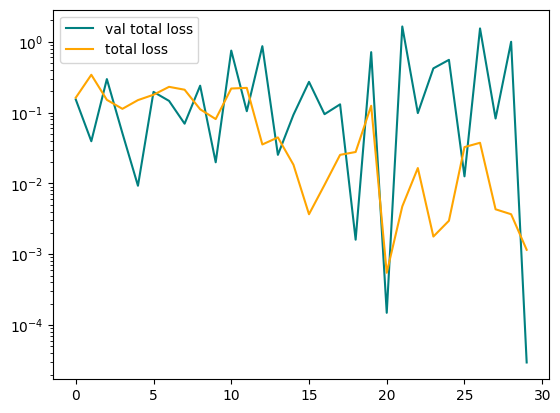

In [111]:
plt.plot(history.history['val_total_loss'], color='teal', label='val total loss')
plt.plot(history.history['total_loss'], color='orange', label='total loss')
plt.legend()

plt.yscale("log")
plt.show()

In [112]:
model.load_weights(os.path.join('checkpoints','checkpoint'))

In [257]:
from tensorflow.keras.models import load_model

In [113]:
emotion_reader.save('emotion_reader.h5')

In [114]:
facetracker = load_model('face_tracker.h5')

In [115]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_4[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_4 (GlobalM (None, 512)          0           vgg16[0][0]                      
____________________________________________________________________________________________

In [116]:
test_data = test.as_numpy_iterator()

In [117]:
X, y = test_data.next()

In [118]:
y_hat = facetracker.predict(X)

In [160]:
num_to_emo = {emotion_dict[emotion]:emotion for emotion in emotion_dict}